

<center>

## **Label noise adaptive semantic segmentation for generating noise-free ultra-high-resolution building maps of Rohingya refugee camps**
### Nahian Ahmed, Rashedur M. Rahman
Department of Electrical and Computer Engineering, North South University, Dhaka, Bangladesh


<!--nahian.ahmed@northsouth.edu-->

<!--nahian@xenoai.org-->

![picture](https://drive.google.com/uc?id=1WfJMpDpqWZMSqObjFhfSostS6lrDlDxv)

</center>

Import packages

In [2]:

import os
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import glob
from zipfile import ZipFile
import random
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from google.colab import drive

drive.mount('/content/gdrive')


Mounted at /content/gdrive


Set seed for reproducibility

In [3]:
seed = 1
tf.random.set_seed(seed)
random.seed(seed)
np.random.seed(seed)

# <b>Dataset overview</b>

### Preprocessing
1. Large raster file of ultra-high-resolution aerial image over Kutupalong megacamp in Bangladesh is tiled to 512x512 patches
2. Images without buildings are removed leading to 5160 patches
3. 50% of dataset is used for training (leading to 2580 tiles) and 10% of testing data (leading to 258 tiles) are used ground truth testing.

### Directory structure

<pre>
data/
├── train/
│   ├── images/
│   ├── noisy_labels_empirical/
│   └── noisy_labels_empirical_synthetic/
└── test/
    ├── images/
    ├── clean_labels/
    ├── noisy_labels_empirical/
    ├── noisy_labels_synthetic/
    └── noisy_labels_empirical_synthetic/
</pre>


### Download data

In [4]:
!gdown https://drive.google.com/uc?id=19WClVDl4sMhtL3lY_2EfhevwkqjNX69S

with ZipFile('data.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

Downloading...
From: https://drive.google.com/uc?id=19WClVDl4sMhtL3lY_2EfhevwkqjNX69S
To: /content/data.zip
1.78GB [00:16, 105MB/s]


### Plot images and labels

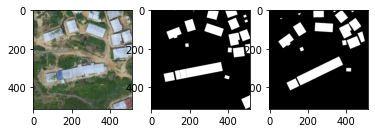

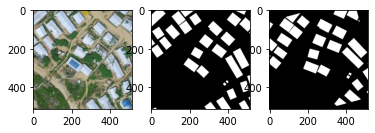

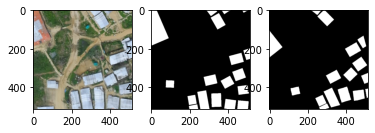

In [6]:
train_filenames = sorted(os.listdir('./data/train/images/img'))

for filename in train_filenames[10:13]:
    image = Image.open('./data/train/images/img/'+filename)
    emp_label = Image.open('./data/train/noisy_labels_empirical/img/'+filename)
    emp_syn_label = Image.open('./data/train/noisy_labels_empirical_synthetic/img/'+filename)
    
    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(image)
    axarr[1].imshow(emp_label,cmap='gray')
    axarr[2].imshow(emp_syn_label,cmap='gray')


# **Segmentation models**

#### Define network architecture

In [ ]:
IMG_HEIGHT = 512
IMG_WIDTH = 512
IMG_CHANNELS = 3

# learning_rate=0.0001

# Build U-Net model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

c1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c5)

u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

model_n = tf.keras.Model(inputs=[inputs], outputs=[outputs])

### Compile

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss=tf.keras.losses.BinaryCrossentropy(), 
    metrics=[tf.keras.metrics.BinaryAccuracy(),
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall(),
            ])
model_n.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss=tf.keras.losses.BinaryCrossentropy(), 
    metrics=[tf.keras.metrics.BinaryAccuracy(),
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall(),
            ])


models = {
    'NOISY-EMPIRICAL' : model,
    'NOISY-EMPIRICAL-SYNTHETIC': model_n
}

models['NOISY-EMPIRICAL'].summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 512, 512, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [ ]:
confs = ['NOISY-EMPIRICAL', 'NOISY-EMPIRICAL-SYNTHETIC']

### Create ImageDataGenerators

In [ ]:
batch_size = 16

image_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
noisy_label_empirical_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
noisy_label_empirical_synthetic_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

image_generator = image_datagen.flow_from_directory(
    'data/train/images/',
    target_size=(512, 512), 
    color_mode='rgb',
    class_mode=None,
    batch_size=batch_size,
    seed=seed)
noisy_label_empirical_generator = noisy_label_empirical_datagen.flow_from_directory(
    'data/train/noisy_labels_empirical/',
    target_size=(512, 512), 
    color_mode='grayscale',
    class_mode=None,
    batch_size=batch_size,
    seed=seed)

noisy_label_empirical_synthetic_generator = noisy_label_empirical_synthetic_datagen.flow_from_directory(
    'data/train/noisy_labels_empirical_synthetic/',
    target_size=(512, 512), 
    color_mode='grayscale',
    class_mode=None,
    batch_size=batch_size,
    seed=seed)

# combine generators into one which yields image and masks
train_noisy_empirical_generator = zip(image_generator, noisy_label_empirical_generator)
train_noisy_empirical_synthetic_generator = zip(image_generator, noisy_label_empirical_synthetic_generator)

train_generators = {
    'NOISY-EMPIRICAL' : train_noisy_empirical_generator,
    'NOISY-EMPIRICAL-SYNTHETIC' : train_noisy_empirical_synthetic_generator,
}


Found 2580 images belonging to 1 classes.
Found 2580 images belonging to 1 classes.
Found 2580 images belonging to 1 classes.


### Train models

In [ ]:
# #Train the two models separately if memory is limited 

# dir = '/content/gdrive/My Drive/buildings_label_noise/models'



# for c in confs[1:]:

#     print('Configuration: '+ c )
#     models[c].fit(
#         train_generators[c],
#         batch_size=batch_size,
#         steps_per_epoch=500,
#         epochs=5, 
#         verbose=1, )
    
#     # Save trained mode
#     models[c].save(f"{dir}/model_"+c+".h5")

In [ ]:
dir = '/content/gdrive/My Drive/buildings_label_noise/models'
models = {
    'NOISY-EMPIRICAL' : tf.keras.models.load_model(f"{dir}/model_NOISY-EMPIRICAL.h5"),
    'NOISY-EMPIRICAL-SYNTHETIC': tf.keras.models.load_model(f"{dir}/model_NOISY-EMPIRICAL-SYNTHETIC.h5")
}

### Plot predictions

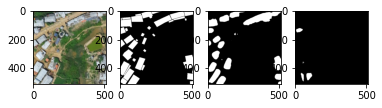

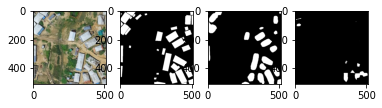

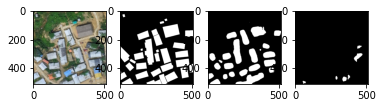

In [ ]:
test_filenames = sorted(os.listdir('./data/test/images/img'))

for filename in test_filenames[43:46]:
    image = Image.open('./data/test/images/img/'+filename)
    clean_label = Image.open('./data/test/clean_labels/img/'+filename)
    pred = models[confs[0]].predict(np.array(image).reshape(1,512,512,3))
    pred = (pred>0.5).astype(int).reshape(512,512)
    pred_n = models[confs[1]].predict(np.array(image).reshape(1,512,512,3))
    pred_n = (pred_n>0.5).astype(int).reshape(512,512)
    
    f, axarr = plt.subplots(1,4)
    axarr[0].imshow(image)
    axarr[1].imshow(clean_label,cmap='gray')
    axarr[2].imshow(pred,cmap='gray')
    axarr[3].imshow(pred_n,cmap='gray')


### Testing

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'

test_filenames = sorted(os.listdir('./data/test/images/img'))


# confs = 2 models/training configurations (defined in previous code)

# testing data
test_confs =  ['CLEAN', 'NOISY-EMPIRICAL', 'NOISY-SYNTHETIC', 'NOISY-EMPIRICAL-SYNTHETIC']

# thresholds
thresholds = [np.round(i,1) for i in np.arange (0.3,0.8,0.1)]

# The final results table should have 7 columns (1-train, 1-test, 1-threshold, 4-metrics) and 40 rows (2 train * 4 test * 5 thresholds)

res_column_names = ['Training data','Testing data','Threshold','Precision','Recall','F1', 'IOU','TP','FP','TN','FN']

res = pd.DataFrame(np.zeros(shape=(40,11)),columns = res_column_names)
# print(res)
res['Training data'] = res['Training data'].astype(object) 
res['Testing data'] = res['Testing data'].astype(object) 



In [ ]:

def results_ (label, pred, r_c):

    fp, tp, fn, tn = tf.keras.metrics.FalsePositives(), tf.keras.metrics.TruePositives(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.TrueNegatives()
    fp.update_state(label,pred)
    tp.update_state(label,pred)
    fn.update_state(label,pred)
    tn.update_state(label,pred)

    res['FP'].iloc[r_c] += fp.result().numpy()
    res['TP'].iloc[r_c] += tp.result().numpy()
    res['FN'].iloc[r_c] += fn.result().numpy()
    res['TN'].iloc[r_c] += tn.result().numpy()


In [ ]:

r_c = 0
for c in confs:
    for t_c in test_confs:  
        for t in thresholds:
            res['Training data'].iloc[r_c]=c
            res['Testing data'].iloc[r_c]=t_c
            res['Threshold'].iloc[r_c]=t
            for filename in test_filenames:  
                image = np.array(Image.open('./data/test/images/img/'+filename))
                pred = models[c].predict(np.array(image).reshape(1,512,512,3))
                pred = (pred>t).astype(int).reshape(512,512)
                label = np.array(Image.open('./data/test/'+t_c.lower().replace('-','_').replace('clean','clean_labels').replace('noisy_','noisy_labels_')+'/img/'+filename))
                results_(label,pred, r_c)
            r_c+=1


for r in range(r_c):
    res['Precision'].iloc[r] = np.round(res['TP'].iloc[r]/(res['TP'].iloc[r]+res['FP'].iloc[r]), 5)
    res['Recall'].iloc[r] = np.round(res['TP'].iloc[r]/(res['TP'].iloc[r]+res['FN'].iloc[r]), 5) 
    res['F1'].iloc[r] = np.round(2*res['TP'].iloc[r]/(2*res['TP'].iloc[r]+res['FP'].iloc[r]+res['FN'].iloc[r]), 5)
    res['IOU'].iloc[r] = np.round(res['TP'].iloc[r]/(res['TP'].iloc[r]+res['FP'].iloc[r]+res['FN'].iloc[r]), 5)

dir = '/content/gdrive/My Drive/buildings_label_noise/results'

# res.to_csv(f"{dir}/results.csv")

### Evaluate test labels against each other

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'

test_filenames = sorted(os.listdir('./data/test/clean_labels/img'))

# testing data
test_confs =  ['NOISY-EMPIRICAL', 'NOISY-SYNTHETIC', 'NOISY-EMPIRICAL-SYNTHETIC']

res_l_column_names = ['Evaluated labels','Evaluated against','Precision','Recall','F1', 'IOU','TP','FP','TN','FN']

res_l = pd.DataFrame(np.zeros(shape=(3,10)),columns = res_l_column_names)
# print(res)
res_l['Evaluated labels'] = res_l['Evaluated labels'].astype(object) 
res_l['Evaluated against'] = res_l['Evaluated against'].astype(object) 


In [ ]:
def results_l_ (clean_label, noisy_label, r_c):

    fp, tp, fn, tn = tf.keras.metrics.FalsePositives(), tf.keras.metrics.TruePositives(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.TrueNegatives()
    fp.update_state(clean_label, noisy_label)
    tp.update_state(clean_label, noisy_label)
    fn.update_state(clean_label, noisy_label)
    tn.update_state(clean_label, noisy_label)

    res_l['FP'].iloc[r_c] += fp.result().numpy()
    res_l['TP'].iloc[r_c] += tp.result().numpy()
    res_l['FN'].iloc[r_c] += fn.result().numpy()
    res_l['TN'].iloc[r_c] += tn.result().numpy()


In [ ]:
r_c=0
for t_c in test_confs:  
    res_l['Evaluated labels'].iloc[r_c]=t_c
    res_l['Evaluated against'].iloc[r_c]='CLEAN'
    for filename in test_filenames:  
        clean_label = np.array(Image.open('./data/test/clean_labels/img/'+filename))
        noisy_label =  np.array(Image.open('./data/test/'+t_c.lower().replace('-','_').replace('noisy_','noisy_labels_')+'/img/'+filename))
        results_l_(clean_label,noisy_label, r_c)
    r_c+=1

for r in range(r_c):
    res_l['Precision'].iloc[r] = np.round(res_l['TP'].iloc[r]/(res_l['TP'].iloc[r]+res_l['FP'].iloc[r]), 5)
    res_l['Recall'].iloc[r] = np.round(res_l['TP'].iloc[r]/(res_l['TP'].iloc[r]+res_l['FN'].iloc[r]), 5) 
    res_l['F1'].iloc[r] = np.round(2*res_l['TP'].iloc[r]/(2*res_l['TP'].iloc[r]+res_l['FP'].iloc[r]+res_l['FN'].iloc[r]), 5)
    res_l['IOU'].iloc[r] = np.round(res_l['TP'].iloc[r]/(res_l['TP'].iloc[r]+res_l['FP'].iloc[r]+res_l['FN'].iloc[r]), 5)

dir = '/content/gdrive/My Drive/buildings_label_noise/results'

res_l.to_csv(f"{dir}/results_labels.csv")

### Select images from training set for calculating hyperparameters

In [ ]:
train_filenames = sorted(os.listdir('./data/train/images/img'))
idx_train = list(range(len(train_filenames)))

random.seed(seed)
random.shuffle(idx_train)

picked_ratio = 0.05 # 5 % of training images are picked for finding the model parameters
idx_picked = idx_train[:int(picked_ratio*len(idx_train))]

picked_filenames = [train_filenames[i] for i in idx_picked]

### Calculate hyperparameters

In [ ]:
picked_pred = []
picked_pred_thresh = []
for filename in picked_filenames:
    image = Image.open('./data/train/images/img/'+filename)
    pred = models['NOISY-EMPIRICAL'].predict(np.array(image).reshape(1,512,512,3))
    picked_pred.append(pred.reshape(512,512))

    pred = (pred>0.5).astype(int).reshape(512,512)
    picked_pred_thresh.append(pred)

# Calculate priors from predictions on selected 5% of training set
picked_pred_thresh = np.array(picked_pred_thresh).flatten()

p_pos = np.sum(picked_pred_thresh)/picked_pred_thresh.size # P(M_hat = 1)
p_neg = (picked_pred_thresh.size - np.sum(picked_pred_thresh))/picked_pred_thresh.size # P(M_hat = 0)

picked_pred = np.array(picked_pred).ravel()


NameError: ignored

#### We model the distribution of predictions using a 2-component Gaussian mixture:

1. Distribution of confident negative predictions,
$$ P(0 \leq \boldsymbol{\hat{M}}_{i,j} \leq \tau_0 )  \sim N(\mu_0, \sigma_0^2) ;\tau_0 \ll 0.5; \tau_0 \neq 0 $$
2. Distribution of confident positive predictions
$$ P(\tau_1 \leq \boldsymbol{\hat{M}}_{i,j} \leq  1)  \sim N(\mu_1, \sigma_1^2)  ; \tau_1 \gg 0.5 ; \tau_0 \neq 1$$
3. Distribution unconfident positive predictions
$$ P(0.5 < \boldsymbol{\hat{M}}_{i,j} <  \tau_1)   \sim N(\mu_{u^+}, \sigma_{u^+}^2)$$
4. Distribution unconfident negative predictions
$$ P(\tau_0 < \boldsymbol{\hat{M}}_{i,j} <  0.5)   \sim N(\mu_{u^-}, \sigma_{u^-}^2)$$


In [ ]:
gm = GaussianMixture(n_components=4, covariance_type='spherical', random_state=seed,).fit(picked_pred.reshape(picked_pred.size,1))

In [ ]:
print(gm.means_)
print(gm.covariances_)

[[0.00906911]
 [0.38344234]
 [0.05898315]
 [0.79813265]]
[4.71417509e-05 3.61959712e-02 1.35275159e-03 7.61566238e-03]


#### We then calculate the two required hyperparameters

<!-- $$ \tau_0 = \mu_0 + 2\sigma_0 $$
$$ \tau_1 = \mu_1 - 2\sigma_1 $$ -->

In [ ]:
mu_0 = float(gm.means_[0])
mu_1 = float(gm.means_[3])

print('mu_0 = ', mu_0, 'mu_1 = ', mu_1)

mu_0 =  0.009069113515451291 mu_1 =  0.7981326530716827


### Plot mixture distriubtion with hyperparameters


P(M_hat=0) = 0.768431730048601 P(M_hat=1) = 0.23156826995139898 P(M_hat=1 or M_hat=0) = 1.0


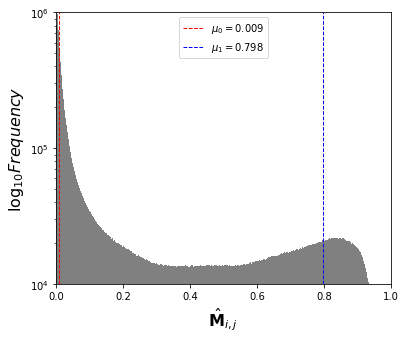

<Figure size 432x288 with 0 Axes>

In [ ]:
print('P(M_hat=0) =', p_neg, 'P(M_hat=1) =', p_pos, 'P(M_hat=1 or M_hat=0) =', p_neg+p_pos )

from matplotlib.pyplot import figure
f=figure(num=None, figsize=(6, 5),  facecolor='w', edgecolor='k')

plt.axis([0, 1, 10000, 1000000])

plt.ylabel(r'$\log_{10}  Frequency $', fontsize=16)
plt.xlabel(r'$\hat{\mathbf{M}}_{i,j}$', fontsize=16)

_ = plt.hist(picked_pred, bins=1000, log=True, color = 'grey')  # arguments are passed to np.histogram

plt.axvline(mu_0, color='r', linestyle='dashed', linewidth=1.0, label=r'$\mu_0 = {:.3f}$'.format(mu_0), c='red')
plt.axvline(mu_1, color='r', linestyle='dashed', linewidth=1.0, label=r'$\mu_1 = {:.3f}$'.format(mu_1), c='blue')


plt.legend(fontsize=10, loc='upper center')
plt.show()
plt.tight_layout()
images_dir = '/content/gdrive/My Drive/buildings_label_noise/figures'
f.savefig(f"{images_dir}/pd_pred.jpg", dpi=1024)